### Requirements

Our implementation leverages several key Python libraries to ensure both computational efficiency and robust analysis:

- **NumPy and SciPy**: Utilized for core mathematical operations, including matrix computations and optimization routines.
- **Numba**: Employed for just-in-time (JIT) compilation to significantly enhance the performance of the algorithm, particularly in iterative and computationally intensive processes.
- **yfinance**: Used to conveniently download historical stock data for free, enabling seamless integration of real-world financial datasets.
- **Statsmodels**: Provides tools for residual analysis, including Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots of the standardized residuals, aiding in model diagnostics and validation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from numba import njit
from dataclasses import dataclass
import statsmodels.api as sm
from scipy.stats import jarque_bera, probplot
import yfinance as yf


### **Conceptual Framework: BEKK-GJR(1,1) Simulation**

The BEKK-GJR(1,1) model describes the dynamics of multivariate volatility with leverage effects, capturing how past shocks and covariances influence current volatilities and correlations. Below, we outline the key mathematical components of the simulation process.

---

#### **1. Conditional Covariance Matrix Evolution**
The conditional covariance matrix \( H_t \) at time \( t \) evolves according to the BEKK-GJR(1,1) specification:

$$
H_t = C C^\top + A^\top \epsilon_{t-1} \epsilon_{t-1}^\top A + B^\top H_{t-1} B + G^\top (\epsilon_{t-1} \epsilon_{t-1}^\top \circ I_{t-1}) G
$$

Where:
- $ H_t $: $ n \times n \ $ conditional covariance matrix at time $ t $.
- $ C $: $ n \times n $ constant lower triangular matrix.
- $ A $: $ n \times n $ coefficient matrix for past residuals.
- $ B $: $ n \times n $ coefficient matrix for past covariances.
- $ G $: $ n \times n $ coefficient matrix for leverage effects.
- $ \epsilon_{t-1} $: $ n $-dimensional vector of residuals at time $ t-1 $.
- $ I_{t-1} $: Diagonal matrix with $ I_{t-1,ii} = 1 $ if $ \epsilon_{t-1,i} < 0 $, and 0 otherwise.
- $ \circ $: Element-wise multiplication (Hadamard product).

---

#### **2. Residual Simulation**
At each forecast step, residuals are simulated from a multivariate normal distribution with mean zero and covariance \( H_t \):

$$
\epsilon_t \sim \mathcal{N}(0, H_t)
$$

This ensures that the simulated residuals reflect the conditional covariance structure at each step.

---

#### **3. Leverage Effect**
The leverage effect is incorporated via the term $ G^\top (\epsilon_{t-1} \epsilon_{t-1}^\top \circ I_{t-1}) G $, which scales the impact of negative shocks on volatility. Specifically:
- $ I_{t-1} $: Identifies which dimensions of $ \epsilon_{t-1} $ are negative.
- $ \epsilon_{t-1} \epsilon_{t-1}^\top \circ I_{t-1} $: Amplifies volatility contributions from negative residuals.

---

#### **4. Monte Carlo Simulation**
The simulation proceeds as follows:
1. **Initialization**: Start with the last observed conditional covariance $ H_{T-1} $ and residual $ \epsilon_{T-1} $ from the training data.
2. **Iterative Forecasting**:
   - Simulate residuals: $ \epsilon_t \sim \mathcal{N}(0, H_t) $.
   - Update $ H_t $ using the BEKK-GJR recursion.
3. **Repeat**: Perform steps 1 and 2 for $ T_{\text{forecast}} $ steps ahead.
4. **Monte Carlo Sampling**: Repeat the process $ N_{\text{samples}} $ times to quantify uncertainty.

---

#### **5. Outputs**
The simulation yields:
1. **Forecasted Covariance Matrices** $ H_t $: Captures the evolution of volatilities and correlations.
2. **Forecasted Residuals** $ \epsilon_t $: Represents random shocks consistent with the covariance dynamics.

These outputs can be used to compute:
- **Conditional Volatilities**: $ \sigma_{t,i} = \sqrt{H_{t,ii}} $.
- **Dynamic Correlations**: $ \rho_{t,ij} = \frac{H_{t,ij}}{\sqrt{H_{t,ii} H_{t,jj}}} $.





### Algorithm Implementation

Before fitting the BEKK-GJR(1,1) model to our data, we need to ensure that the algorithm is correctly implemented and meets the model specifications.

In [2]:
def simulate_bekk_gjr(n_obs, C, A, B, G, mu=None):
    """
    Simulate a BEKK-GJR(1,1) multivariate process.

    Args:
        n_obs (int): Number of observations.
        C (np.ndarray): Constant term (n_dims, n_dims).
        A (np.ndarray): Coefficient matrix for lagged residuals (n_dims, n_dims).
        B (np.ndarray): Coefficient matrix for lagged covariances (n_dims, n_dims).
        G (np.ndarray): Coefficient matrix for asymmetry (n_dims, n_dims).
        mu (np.ndarray): Mean vector (n_dims,).

    Returns:
        np.ndarray: Simulated time series (n_obs, n_dims).
        np.ndarray: Simulated conditional covariance matrices (n_obs, n_dims, n_dims).
    """
    n_dims = C.shape[0]
    y = np.zeros((n_obs, n_dims))
    H = np.zeros((n_obs, n_dims, n_dims))
    eps = np.random.randn(n_obs, n_dims)

    if mu is None:
        mu = np.zeros(n_dims)

    # Initialize
    H[0] = C @ C.T
    y[0] = mu + np.random.multivariate_normal(np.zeros(n_dims), H[0])

    for t in range(1, n_obs):
        # Compute residuals
        epsilon = y[t-1] - mu
        I_neg = np.diag((epsilon < 0).astype(float))  # Indicator for negative residuals
        
        # Update covariance
        H[t] = (C @ C.T +
                A.T @ np.outer(epsilon, epsilon) @ A +
                B.T @ H[t-1] @ B +
                G.T @ (np.outer(epsilon, epsilon) * I_neg) @ G)
        
        # Simulate new observation
        y[t] = mu + np.random.multivariate_normal(np.zeros(n_dims), H[t])
    
    return y, H


### BEKK-GJR(1,1) Model Simulation

In this cell, we define the `simulate_bekk_gjr` function, which simulates a BEKK-GJR(1,1) multivariate process. The function takes the number of observations, constant term, coefficient matrices for lagged residuals, covariances, and leverage effects as inputs. It returns the simulated time series and conditional covariance matrices. The simulation process involves initializing the covariance matrix and iteratively updating it based on the BEKK-GJR(1,1) specification.

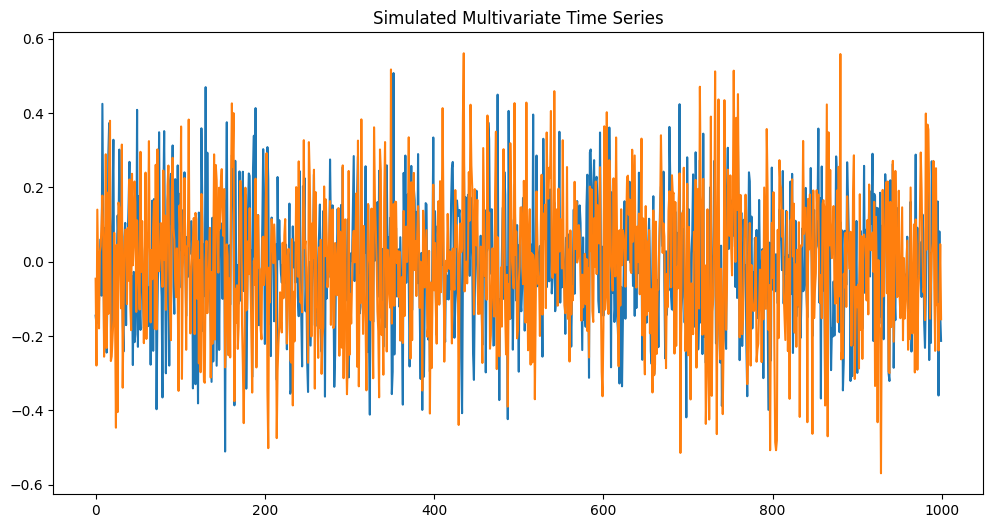

In [3]:
n_dims = 2
n_obs = 1000
C = np.array([[0.1, 0.0], [0.05, 0.1]])
A = np.eye(n_dims) * 0.1
B = np.eye(n_dims) * 0.8
G = np.eye(n_dims) * 0.2

# Simulate data
y, H = simulate_bekk_gjr(n_obs, C, A, B, G)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y)
plt.title("Simulated Multivariate Time Series")
plt.show()

### Plotting Variances and Correlations

In the next three cells, we will visualize the variances and correlations of the simulated data:

1. **Plotting Conditional Variances**: We will plot the conditional variances over time for each dimension of the simulated data. This helps us understand the dynamic behavior of the variances.

2. **Plotting Conditional Correlations**: We will plot the conditional correlations over time for each pair of dimensions. This allows us to observe how the correlations between different dimensions evolve over time.

In [4]:
def extract_variances_and_correlations(H):
    """
    Extract variances and correlations from covariance matrices.

    Args:
        H (np.ndarray): Covariance matrices (n_obs, n_dims, n_dims).

    Returns:
        variances (np.ndarray): Variances (n_obs, n_dims).
        correlations (np.ndarray): Correlations (n_obs, n_dims, n_dims).
    """
    n_obs, n_dims, _ = H.shape
    variances = np.zeros((n_obs, n_dims))
    correlations = np.zeros((n_obs, n_dims, n_dims))

    for t in range(n_obs):
        variances[t] = np.diag(H[t])  # Extract variances
        stddevs = np.sqrt(np.diag(H[t]))
        correlations[t] = H[t] / np.outer(stddevs, stddevs)  # Convert covariance to correlation
        np.fill_diagonal(correlations[t], 1.0)  # Ensure diagonal is exactly 1

    return variances, correlations

In [5]:
def plot_variances_and_correlations(variances, correlations):
    """
    Plot variances and correlations over time.

    Args:
        variances (np.ndarray): Variances (n_obs, n_dims).
        correlations (np.ndarray): Correlations (n_obs, n_dims, n_dims).
    """
    n_obs, n_dims = variances.shape

    # Plot variances
    plt.figure(figsize=(12, 6))
    for i in range(n_dims):
        plt.plot(variances[:, i], label=f"Variance (Dim {i+1})")
    plt.title("Conditional Variances Over Time")
    plt.xlabel("Time")
    plt.ylabel("Variance")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot correlations
    for i in range(n_dims):
        for j in range(i + 1, n_dims):  # Only plot off-diagonal correlations
            plt.figure(figsize=(12, 6))
            plt.plot(correlations[:, i, j], label=f"Correlation (Dim {i+1} vs Dim {j+1})")
            plt.title(f"Conditional Correlation Between Dim {i+1} and Dim {j+1}")
            plt.xlabel("Time")
            plt.ylabel("Correlation")
            plt.legend()
            plt.grid()
            plt.show()

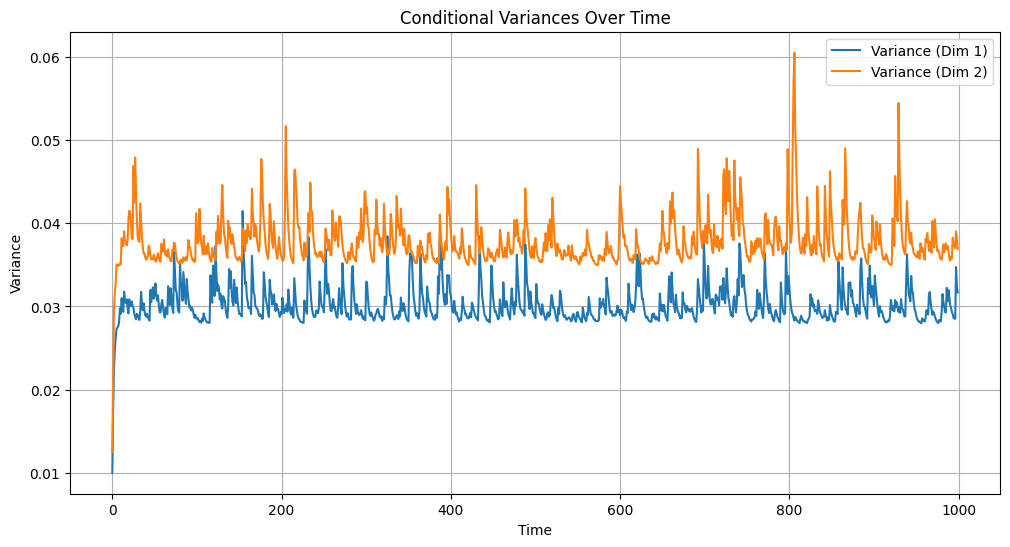

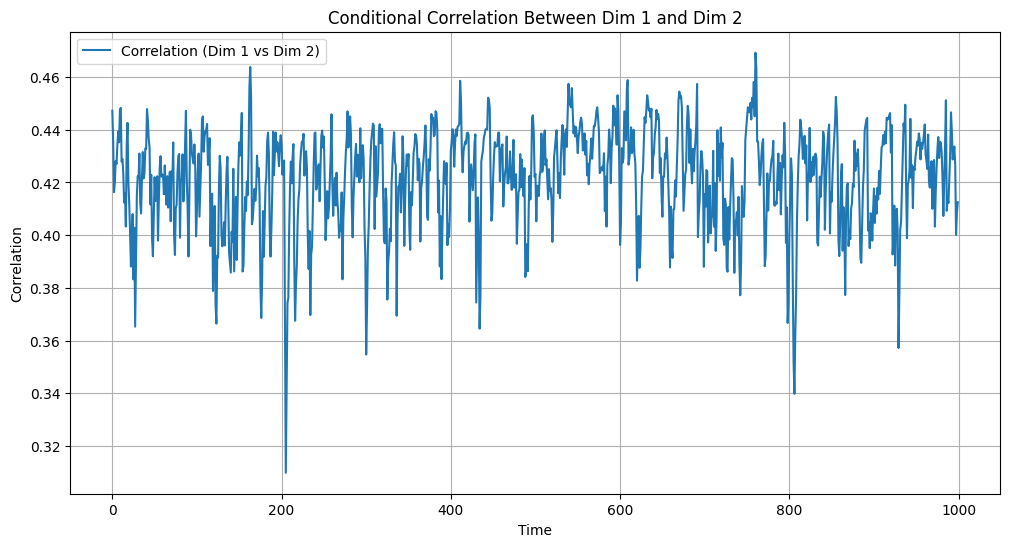

In [6]:
variances, correlations = extract_variances_and_correlations(H)

# Plot results
plot_variances_and_correlations(variances, correlations)

### Model Implementation Overview

The implementation of the BEKK-GJR(1,1) model in the cells below is structured to leverage both top-level Just-In-Time (JIT) compiled functions and a dataclass to encapsulate the model's parameters and methods. This design ensures that the computationally intensive parts of the model are optimized for performance using Numba's JIT compilation, while providing a clean and organized interface for working with the model.

#### Key Components

1. **Top-Level JIT Functions**:
    - **`multivariate_normal_rvs`**: Samples from a multivariate normal distribution.
    - **`forecast_bekk_gjr`**: Forecasts future conditional covariances and residuals.
    - **`compute_standardized_residuals`**: Computes standardized residuals.
    - **`compute_bekk_gjr_covariances`**: Computes conditional covariance matrices.
    - **`bekk_gjr_log_likelihood`**: Computes the log-likelihood for the BEKK-GJR(1,1) model.

2. **Dataclass**:
    - **`MGARCH_GJR`**: Encapsulates the model parameters and provides methods for fitting, forecasting, and diagnostics.

#### Detailed Breakdown

1. **Top-Level JIT Functions**:
    - **`multivariate_normal_rvs`**:
      ```python
      @njit
      def multivariate_normal_rvs(mean, cov):
            dim = mean.shape[0]
            z = np.random.randn(dim)
            L = np.linalg.cholesky(cov.T)
            sample = mean + L @ z
            return sample
      ```
      This function samples from a multivariate normal distribution using Cholesky decomposition for efficiency.

    - **`forecast_bekk_gjr`**:
      ```python
      @njit
      def forecast_bekk_gjr(y, T_forecast, C, A, B, G, mu):
            n_obs, n_dims = y.shape
            epsilon_past = y[-1] - mu
            H_past = compute_bekk_gjr_covariances(y, C, A, B, G, mu)[-1]
            H_forecast = np.zeros((T_forecast, n_dims, n_dims))
            eps_forecast = np.zeros((T_forecast, n_dims))

            H_t = H_past.copy()
            epsilon_t = epsilon_past.copy()

            for t in range(T_forecast):
                 epsilon_t = multivariate_normal_rvs(np.zeros(n_dims), H_t)
                 I_neg = np.diag((epsilon_t < 0))
                 H_t = (C @ C.T + A.T @ np.outer(epsilon_t, epsilon_t) @ A + B.T @ H_t @ B + G.T @ (np.outer(epsilon_t, epsilon_t) * I_neg) @ G)
                 H_t += 1e-6 * np.eye(n_dims)
                 H_forecast[t] = H_t
                 eps_forecast[t] = epsilon_t

            return H_forecast, eps_forecast
      ```
      This function forecasts future conditional covariances and residuals by simulating future residuals and updating the covariance matrix iteratively.

    - **`compute_standardized_residuals`**:
      ```python
      def compute_standardized_residuals(y, mu, H):
            n_obs, n_dims = y.shape
            residuals = y - mu
            std_residuals = np.zeros_like(residuals)

            for t in range(n_obs):
                 std_devs = np.sqrt(np.diag(H[t]))
                 std_residuals[t] = residuals[t] / std_devs

            return std_residuals
      ```
      This function computes standardized residuals by dividing the residuals by their conditional standard deviations.

    - **`compute_bekk_gjr_covariances`**:
      ```python
      @njit
      def compute_bekk_gjr_covariances(y, C, A, B, G, mu=None):
            n_obs, n_dims = y.shape
            H = np.zeros((n_obs, n_dims, n_dims))

            if mu is None:
                 mu = np.zeros(n_dims)

            H[0] = C @ C.T

            for t in range(1, n_obs):
                 epsilon = y[t-1] - mu
                 I_neg = np.diag((epsilon < 0))
                 H[t] = (C @ C.T + A.T @ np.outer(epsilon, epsilon) @ A + B.T @ H[t-1] @ B + G.T @ (np.outer(epsilon, epsilon) * I_neg) @ G)

            return H
      ```
      This function computes the conditional covariance matrices for the BEKK-GJR(1,1) model using the model parameters and observed data.

    - **`bekk_gjr_log_likelihood`**:
      ```python
      @njit
      def bekk_gjr_log_likelihood(params, y, n_dims):
            n_obs = y.shape[0]
            C = params[:n_dims**2].reshape(n_dims, n_dims)
            A = params[n_dims**2:n_dims**2*2].reshape(n_dims, n_dims)
            B = params[n_dims**2*2:n_dims**2*3].reshape(n_dims, n_dims)
            G = params[n_dims**2*3:].reshape(n_dims, n_dims)
            H = compute_bekk_gjr_covariances(y, C, A, B, G)
            ll = 0

            for t in range(n_obs):
                 epsilon_t = y[t]
                 ll += (np.log(np.linalg.det(H[t])) + epsilon_t.T @ np.linalg.inv(H[t]) @ epsilon_t)

            return 0.5 * ll
      ```
      This function computes the log-likelihood for the BEKK-GJR(1,1) model, which is used for parameter estimation.

2. **Dataclass**:
    - **`MGARCH_GJR`**:
      ```python
      @dataclass
      class MGARCH_GJR:
            C: np.ndarray
            A: np.ndarray
            B: np.ndarray
            G: np.ndarray
            mu: np.ndarray

            @classmethod
            def from_params(cls, params, n_dims):
                 C = params[:n_dims**2].reshape(n_dims, n_dims)
                 A = params[n_dims**2:n_dims**2*2].reshape(n_dims, n_dims)
                 B = params[n_dims**2*2:n_dims**2*3].reshape(n_dims, n_dims)
                 G = params[n_dims**2*3:].reshape(n_dims, n_dims)
                 return cls(C, A, B, G, np.zeros(n_dims))

            def conditional_covariances(self, y):
                 return compute_bekk_gjr_covariances(y, self.C, self.A, self.B, self.G, self.mu)

            def standardized_residuals(self, y):
                 H = self.conditional_covariances(y)
                 return compute_standardized_residuals(y, self.mu, H)

            def log_likelihood(self, y):
                 H = self.conditional_covariances(y)
                 ll = 0

                 for t in range(len(y)):
                      epsilon = y[t] - self.mu
                      ll += (np.log(np.linalg.det(H[t])) + epsilon.T @ np.linalg.inv(H[t]) @ epsilon)

                 return -0.5 * ll

            def sample_forecast(self, y, T_forecast=30, n_samples=100):
                 n_dims = self.C.shape[0]
                 samples = np.zeros((n_samples, T_forecast, n_dims))
                 H_samples = np.zeros((n_samples, T_forecast, n_dims, n_dims))

                 for n in range(n_samples):
                      H_forecast, eps_forecast = forecast_bekk_gjr(y, T_forecast, self.C, self.A, self.B, self.G, self.mu)
                      H_samples[n] = H_forecast
                      samples[n] = self.mu + eps_forecast

                 return samples, H_samples
      ```
      The `MGARCH_GJR` dataclass encapsulates the model parameters and provides methods for:
      - **`from_params`**: Creating an instance from flattened parameters.
      - **`conditional_covariances`**: Computing conditional covariance matrices.
      - **`standardized_residuals`**: Computing standardized residuals.
      - **`log_likelihood`**: Computing the log-likelihood.
      - **`sample_forecast`**: Generating Monte Carlo sample forecasts.


In [13]:

@njit
def multivariate_normal_rvs(mean, cov):
    """Sample from multivariate normal distribution."""
    dim = mean.shape[0]
    z = np.random.randn(dim)
    L = np.linalg.cholesky(cov.T)
    sample = mean + L @ z
    
    return sample



@njit
def forecast_bekk_gjr(y, T_forecast, C, A, B, G, mu):
    """
    Forecast future conditional covariances and residuals for the BEKK-GJR(1,1) model,
    introducing randomness into the covariances by simulating future residuals.

    Args:
        y (np.ndarray): Observed time series (n_obs, n_dims).
        model (MGARCH_GJR): Fitted BEKK-GJR model instance.
        T_forecast (int): Number of forecast periods.

    Returns:
        np.ndarray: Forecasted covariance matrices (T_forecast, n_dims, n_dims).
        np.ndarray: Simulated residuals (T_forecast, n_dims).
    """
    n_obs, n_dims = y.shape
    # Start from the last observed H
    epsilon_past = y[-1] - mu  # last residual

    H_past = compute_bekk_gjr_covariances(y, C, A, B, G, mu)[-1]  # last covariance
    H_forecast = np.zeros((T_forecast, n_dims, n_dims))
    eps_forecast = np.zeros((T_forecast, n_dims))

    H_t = H_past.copy()
    epsilon_t = epsilon_past.copy()

    for t in range(T_forecast):
        # Simulate next epsilon from N(0, H_t)
        epsilon_t = multivariate_normal_rvs(np.zeros(n_dims), H_t)

        # Indicator for negative residuals
        I_neg = np.diag((epsilon_t < 0))

        # Update next covariance
        H_t = (C @ C.T +
               A.T @ np.outer(epsilon_t, epsilon_t) @ A +
               B.T @ H_t @ B +
               G.T @ (np.outer(epsilon_t, epsilon_t) * I_neg) @ G)

        # Regularize for numerical stability
        H_t += 1e-6 * np.eye(n_dims)

        H_forecast[t] = H_t
        eps_forecast[t] = epsilon_t

    return H_forecast, eps_forecast

def compute_standardized_residuals(y, mu, H):
    """
    Compute standardized residuals for the BEKK-GJR model.

    Args:
        y (np.ndarray): Time series (n_obs, n_dims).
        mu (np.ndarray): Mean vector (n_dims,).
        H (np.ndarray): Conditional covariance matrices (n_obs, n_dims, n_dims).

    Returns:
        np.ndarray: Standardized residuals (n_obs, n_dims).
    """
    n_obs, n_dims = y.shape
    residuals = y - mu  # Compute residuals
    std_residuals = np.zeros_like(residuals)

    for t in range(n_obs):
        std_devs = np.sqrt(np.diag(H[t]))  # Extract conditional standard deviations
        std_residuals[t] = residuals[t] / std_devs

    return std_residuals

def extract_variances_and_correlations(H):
    """
    Extract variances and correlations from covariance matrices.

    Args:
        H (np.ndarray): Covariance matrices (n_obs, n_dims, n_dims).

    Returns:
        variances (np.ndarray): Variances (n_obs, n_dims).
        correlations (np.ndarray): Correlations (n_obs, n_dims, n_dims).
    """
    n_obs, n_dims, _ = H.shape
    variances = np.zeros((n_obs, n_dims))
    correlations = np.zeros((n_obs, n_dims, n_dims))

    for t in range(n_obs):
        variances[t] = np.diag(H[t])  # Extract variances
        stddevs = np.sqrt(np.diag(H[t]))
        correlations[t] = H[t] / np.outer(stddevs, stddevs)  # Convert covariance to correlation
        np.fill_diagonal(correlations[t], 1.0)  # Ensure diagonal is exactly 1

    return variances, correlations

@njit
def compute_bekk_gjr_covariances(y, C, A, B, G, mu=None):
    """
    Compute conditional covariance matrices for a BEKK-GJR(1,1) model.

    Args:
        y (np.ndarray): Time series (n_obs, n_dims).
        C, A, B, G (np.ndarray): Model parameters.
        mu (np.ndarray): Mean vector.

    Returns:
        np.ndarray: Conditional covariance matrices (n_obs, n_dims, n_dims).
    """
    n_obs, n_dims = y.shape
    H = np.zeros((n_obs, n_dims, n_dims))  # To store the conditional covariance matrices

    if mu is None:
        mu = np.zeros(n_dims)

    # Initialize
    H[0] = C @ C.T

    for t in range(1, n_obs):
        epsilon = y[t-1] - mu  # Lagged residuals
        I_neg = np.diag((epsilon < 0))  # Indicator for negative residuals

        # Compute the conditional covariance matrix
        H[t] = (C @ C.T +
                A.T @ np.outer(epsilon, epsilon) @ A +
                B.T @ H[t-1] @ B +
                G.T @ (np.outer(epsilon, epsilon) * I_neg) @ G)
        

    return H

@njit
def bekk_gjr_log_likelihood(params, y, n_dims):
    """
    Compute the log-likelihood for the BEKK-GJR(1,1) model.

    Args:
        params (np.ndarray): Flattened model parameters.
        y (np.ndarray): Time series (n_obs, n_dims).
        n_dims (int): Number of dimensions.

    Returns:
        float: Negative log-likelihood.
    """
    n_obs = y.shape[0]

    # Reshape parameters
    C = params[:n_dims**2].reshape(n_dims, n_dims)
    A = params[n_dims**2:n_dims**2*2].reshape(n_dims, n_dims)
    B = params[n_dims**2*2:n_dims**2*3].reshape(n_dims, n_dims)
    G = params[n_dims**2*3:].reshape(n_dims, n_dims)

    # Compute conditional covariances
    H = compute_bekk_gjr_covariances(y, C, A, B, G)

    # Compute log-likelihood
    ll = 0
    for t in range(n_obs):
        epsilon_t = y[t]
        ll += (np.log(np.linalg.det(H[t])) +
                epsilon_t.T @ np.linalg.inv(H[t]) @ epsilon_t)

    return 0.5 * ll  # Return negative log-likelihood for minimization




@dataclass
class MGARCH_GJR:
    C: np.ndarray
    A: np.ndarray
    B: np.ndarray
    G: np.ndarray
    mu: np.ndarray

    @classmethod
    def from_params(cls, params, n_dims):
        C = params[:n_dims**2].reshape(n_dims, n_dims)
        A = params[n_dims**2:n_dims**2*2].reshape(n_dims, n_dims)
        B = params[n_dims**2*2:n_dims**2*3].reshape(n_dims, n_dims)
        G = params[n_dims**2*3:].reshape(n_dims, n_dims)
        return cls(C, A, B, G, np.zeros(n_dims))

    def conditional_covariances(self, y):
        """
        Compute conditional covariances for the fitted model.

        Args:
            y (np.ndarray): Time series (n_obs, n_dims).

        Returns:
            np.ndarray: Conditional covariance matrices (n_obs, n_dims, n_dims).
        """
        return compute_bekk_gjr_covariances(y, self.C, self.A, self.B, self.G, self.mu)

    def standardized_residuals(self, y):
        """
        Compute standardized residuals for the time series.

        Args:
            y (np.ndarray): Observed time series (n_obs, n_dims).

        Returns:
            np.ndarray: Standardized residuals (n_obs, n_dims).
        """
        H = self.conditional_covariances(y)
        return compute_standardized_residuals(y, self.mu, H)

    def log_likelihood(self, y):
        """
        Compute the log-likelihood for the model and the time series.

        Args:
            y (np.ndarray): Time series (n_obs, n_dims).

        Returns:
            float: Log-likelihood value.
        """
        H = self.conditional_covariances(y)
        ll = 0

        for t in range(len(y)):
            epsilon = y[t] - self.mu
            ll += (np.log(np.linalg.det(H[t])) +
                   epsilon.T @ np.linalg.inv(H[t]) @ epsilon)

        return -0.5 * ll
    
    def sample_forecast(self, y, T_forecast=30, n_samples=100):
        """
        Generate Monte Carlo sample forecasts with randomness in both residuals and covariances.
        At each step, new residuals are drawn from N(0, H_t), influencing future covariances.

        Args:
            y (np.ndarray): Observed time series (n_obs, n_dims).
            T_forecast (int): Number of forecast periods.
            n_samples (int): Number of Monte Carlo samples.

        Returns:
            np.ndarray: Sample forecasted time series (n_samples, T_forecast, n_dims).
            np.ndarray: Corresponding forecasted covariances (n_samples, T_forecast, n_dims, n_dims).
        """
        n_dims = self.C.shape[0]
        samples = np.zeros((n_samples, T_forecast, n_dims))
        H_samples = np.zeros((n_samples, T_forecast, n_dims, n_dims))

        for n in range(n_samples):
            H_forecast, eps_forecast = forecast_bekk_gjr(y, T_forecast, self.C, self.A, self.B, self.G, self.mu)
            H_samples[n] = H_forecast
            # Given eps_forecast are the simulated residuals, we simulate y from mu + eps_forecast
            # Actually, eps_forecast are already from N(0,H_t). To get y, add mu:
            # Note: In a GARCH model, epsilon_t = y_t - mu. We drew epsilon_t ~ N(0,H_t)
            # thus y_t = mu + epsilon_t.
            samples[n] = self.mu + eps_forecast

        return samples, H_samples
    
def extract_correlation_matrix(H):
    """
    Extract correlation matrices from covariance matrices.

    Args:
        H (np.ndarray): Covariance matrices (n_obs, n_dims, n_dims).

    Returns:
        np.ndarray: Correlation matrices (n_obs, n_dims, n_dims).
    """
    n_obs, n_dims, _ = H.shape
    correlations = np.zeros((n_obs, n_dims, n_dims))

    for t in range(n_obs):
        stddevs = np.sqrt(np.diag(H[t]))
        correlations[t] = H[t] / np.outer(stddevs, stddevs)
        np.fill_diagonal(correlations[t], 1.0)  # Ensure diagonal is exactly 1

    return correlations


### Choice of Symbols and Data Parameters

#### Symbols
We have chosen three large US banks: JPMorgan Chase (JPM), Bank of America (BAC), and Goldman Sachs (GS). These institutions are significant players in the financial sector, and their stock prices are influenced by a variety of macroeconomic factors, making them suitable for volatility modeling.

#### Date Range
The date range for the data spans from January 1, 2019, to December 6, 2024. This period includes various market conditions, such as the pre-pandemic period, the COVID-19 pandemic, and the subsequent recovery phase. This range provides a comprehensive dataset for modeling and forecasting volatility.

#### Adjusted Close
We use the adjusted close prices to account for corporate actions such as dividends, stock splits, and other adjustments. This ensures that the data reflects the true value of the stocks over time, providing a more accurate basis for analysis.

#### Test Size
A test size of 30 trading days is chosen to evaluate the model's out-of-sample forecasting performance. This allows us to assess how well the model generalizes to unseen data, which is crucial for its practical application in financial forecasting.

#### Model Parameters (p and q)
We set the parameters $ p $ and $ q $ to 1, indicating a BEKK-GJR(1,1) model.

In [16]:

syms = ['JPM', 'BAC', 'GS']
n_dims = len(syms)
fit = True
test_size = 30
p = 1
q = 1


data = yf.download(syms, start='2019-01-01', end='2024-12-06')['Adj Close']
y = np.log(data).diff().dropna()

y_matrix = y.values
timestamps = y.index
test_size = 30

y_train = y_matrix[:-test_size]
y_test = y_matrix[-test_size:]
train_timestamps = timestamps[:-test_size]
test_timestamps = timestamps[-test_size:]



[*********************100%***********************]  3 of 3 completed


### Model Fitting

We use historical training data to estimate the parameters of the BEKK-GJR(1,1) model. The parameters are optimized to maximize the log-likelihood function, ensuring the best fit to the observed data.

#### Implementation Details:
- **Optimization**: The `scipy.optimize.minimize` function is used to estimate parameters, constrained to ensure stationarity.
- **Just-in-Time Compilation**: With `numba`, we accelerate computationally intensive parts of the algorithm, such as matrix updates for \( H_t \).

In [ ]:
def fit_bekk_gjr(y, n_dims):
    """
    Fit the BEKK-GJR(1,1) model to data.

    Args:
        y (np.ndarray): Time series (n_obs, n_dims).
        n_dims (int): Number of dimensions.

    Returns:
        scipy.optimize.OptimizeResult: Optimization result containing estimated parameters.
    """
    # Initial parameter guesses
    C_init = np.eye(n_dims) * 0.1  # Lower triangular constant matrix
    A_init = np.eye(n_dims) * 0.1  # Coefficient for residuals
    B_init = np.eye(n_dims) * 0.1  # Coefficient for covariances
    G_init = np.eye(n_dims) * 0.1  # Coefficient for leverage effects
    initial_params = np.concatenate([C_init.flatten(), A_init.flatten(), B_init.flatten(), G_init.flatten()])

    def objective(params, y, n_dims):
        """
        Objective function for the BEKK-GJR model.

        Args:
            params (np.ndarray): Flattened model parameters.
            y (np.ndarray): Time series (n_obs, n_dims).
            n_dims (int): Number of dimensions.

        Returns:
            float: Negative log-likelihood.
        """
        try:
            return bekk_gjr_log_likelihood(params, y, n_dims)
        except np.linalg.LinAlgError:
            return np.inf
    
    # Minimize the negative log-likelihood
    result = minimize(
        objective,  # Objective function
        initial_params,           # Initial guess
        args=(y, n_dims),         # Additional arguments to the function
        options={"disp": True, "maxiter": 500}  # Display progress and limit iterations
    )

    return result

result = fit_bekk_gjr(y_train, n_dims)
model = MGARCH_GJR.from_params(result.x, n_dims)

### In-Sample Analysis and Forecasting

In this section, we perform several key analyses on the in-sample data and generate forecasts using the fitted BEKK-GJR(1,1) model:

1. **Conditional Covariances**: We compute the conditional covariance matrices for the in-sample data using the fitted model parameters. This helps us understand the dynamic relationships between the variables over time.

2. **Standardized Residuals**: We calculate the standardized residuals, which are the residuals divided by their conditional standard deviations. These residuals are used to assess the model's fit and to perform diagnostic checks.

3. **Normality Tests**: We conduct normality tests on the standardized residuals to check if they follow a normal distribution. This includes the Jarque-Bera test and QQ plots. We find that the tails of the distributions are heavier than the normal distribution, which is not unexpected.  This can be improved on by using the t-distribution with some degrees of freedom that better match the tails or else some other distribution, such as a stable distribution.

4. **Standardized Residuals Plot**: We visualize the standardized residuals over time to identify any patterns or anomalies.

5. **Autocorrelation Analysis**: We plot the autocorrelation function (ACF) and partial autocorrelation function (PACF) of the standardized residuals to check for any remaining autocorrelation that the model might not have captured.  We find that the model essentially removes autocorrelation in the residuals.

The code cell below executes these analyses and visualizations to ensure the robustness and accuracy of our fitted BEKK-GJR(1,1) model.

Dim 1 - Jarque-Bera Test: stat=311.52, p-value=0.0000


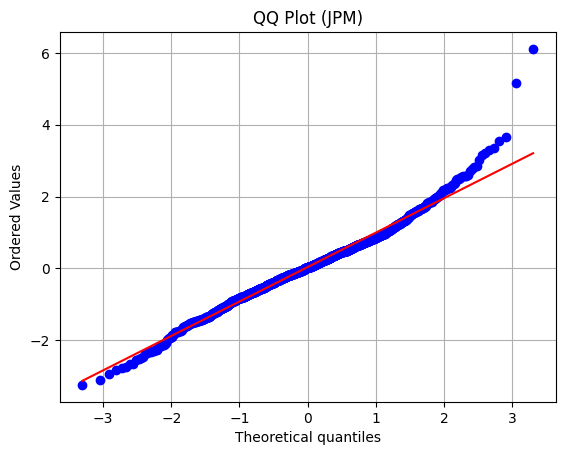

Dim 2 - Jarque-Bera Test: stat=456.16, p-value=0.0000


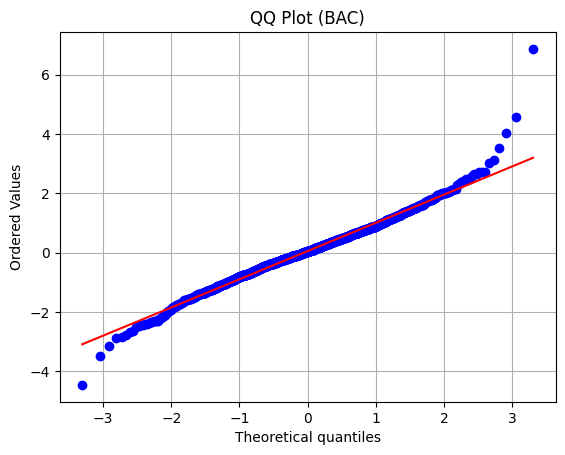

Dim 3 - Jarque-Bera Test: stat=515.17, p-value=0.0000


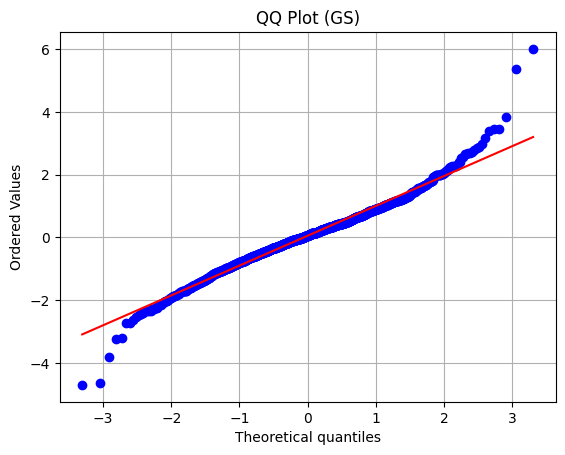

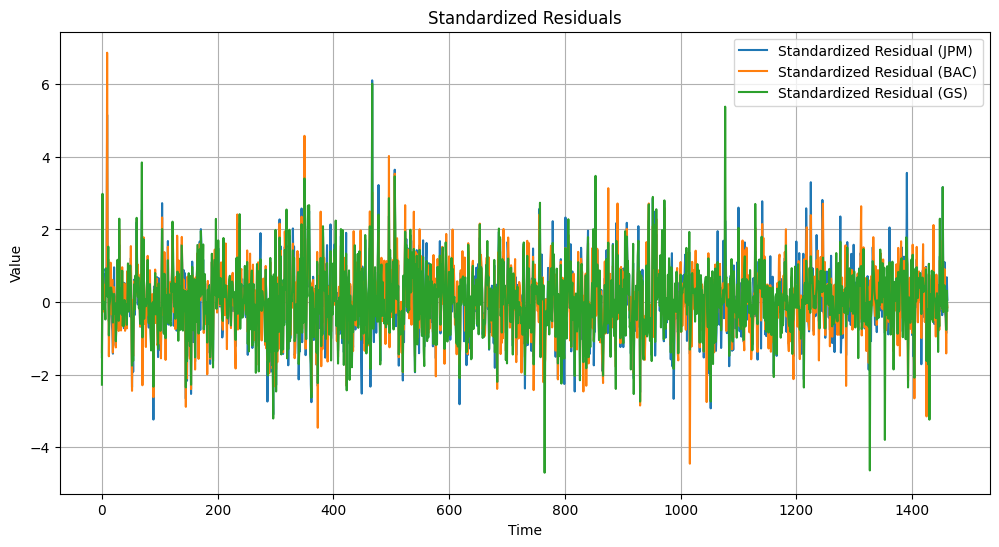

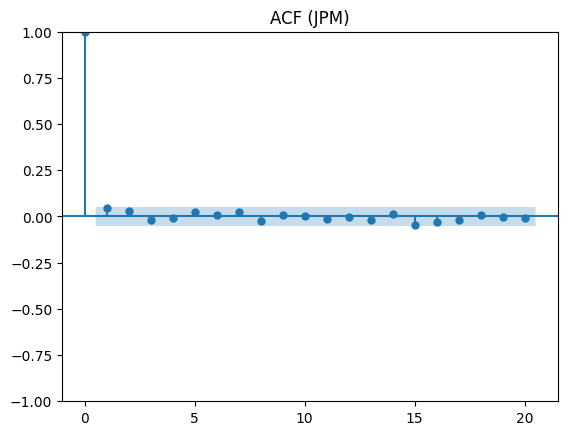

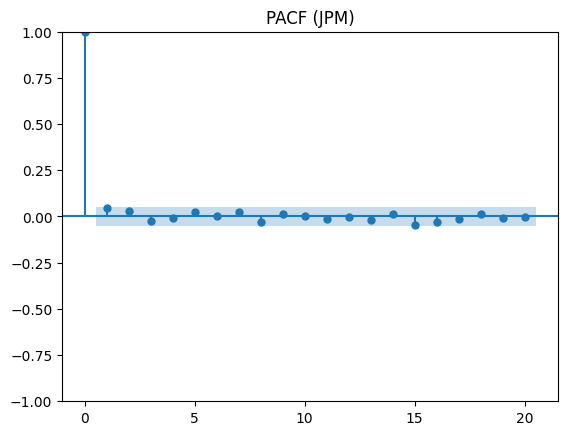

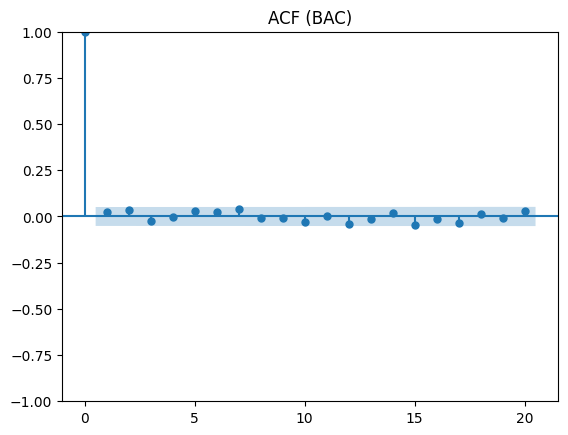

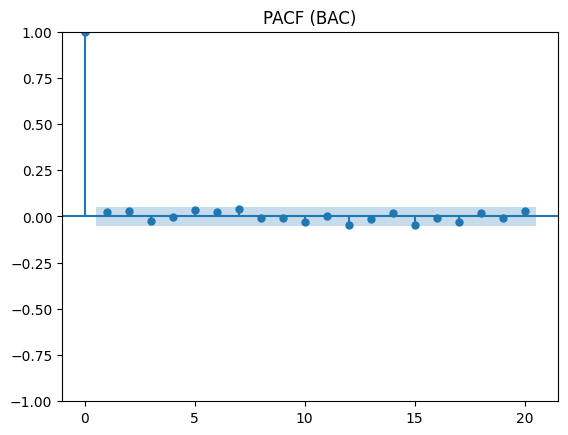

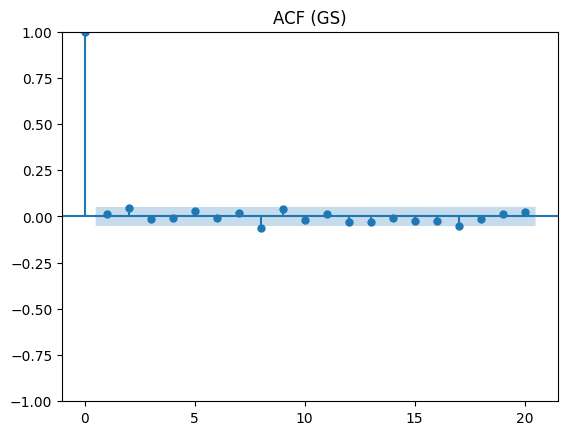

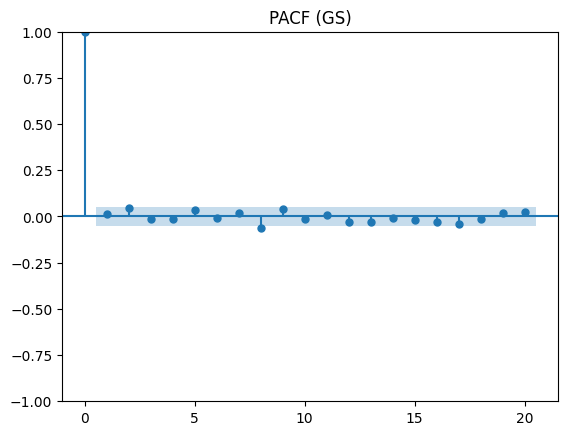

In [17]:
def normality_tests(std_residuals, syms):
    """
    Perform normality tests on standardized residuals.

    Args:
        std_residuals (np.ndarray): Standardized residuals (n_obs, n_dims).
    """
    n_dims = std_residuals.shape[1]

    for i in range(n_dims):
        # Jarque-Bera Test
        jb_stat, jb_pval = jarque_bera(std_residuals[:, i])
        print(f"Dim {i+1} - Jarque-Bera Test: stat={jb_stat:.2f}, p-value={jb_pval:.4f}")

        # QQ Plot
        probplot(std_residuals[:, i], dist="norm", plot=plt)
        plt.title(f"QQ Plot ({syms[i]})")
        plt.grid()
        plt.show()

def plot_autocorrelation(std_residuals, syms):
    """
    Plot autocorrelation and partial autocorrelation for each dimension.

    Args:
        std_residuals (np.ndarray): Standardized residuals (n_obs, n_dims).
    """
    n_dims = std_residuals.shape[1]

    for i in range(n_dims):
        sm.graphics.tsa.plot_acf(std_residuals[:, i], lags=20, title=f"ACF ({syms[i]})")
        sm.graphics.tsa.plot_pacf(std_residuals[:, i], lags=20, title=f"PACF ({syms[i]})")
        plt.show()
        
def plot_standardized_residuals(std_residuals, syms):
    """
    Plot standardized residuals for each dimension.

    Args:
        std_residuals (np.ndarray): Standardized residuals (n_obs, n_dims).
    """
    n_obs, n_dims = std_residuals.shape
    plt.figure(figsize=(12, 6))

    for i in range(n_dims):
        plt.plot(std_residuals[:, i], label=f"Standardized Residual ({syms[i]})")
    
    plt.title("Standardized Residuals")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid()
    plt.show()
    
in_sample_H = model.conditional_covariances(y_train)

# Compute standardized residuals
std_residuals = model.standardized_residuals(y_train)

# Perform normality tests
normality_tests(std_residuals, syms)

# Plot standardized residuals
plot_standardized_residuals(std_residuals, syms)

# Plot autocorrelation and partial autocorrelation
plot_autocorrelation(std_residuals, syms)





### Sample Forecast Analysis

The sample forecast appears to capture the variability of the series well. The grey cloud, representing the 90% confidence interval of the forecasted paths, covers the actual blue residuals reasonably well. This indicates that the model's forecasted variability aligns closely with the observed data, suggesting that the confidence intervals are a good approximation of the true uncertainty in the series. The coverage of the grey cloud over the actual residuals demonstrates the model's effectiveness in capturing the dynamic behavior and variability of the financial time series.

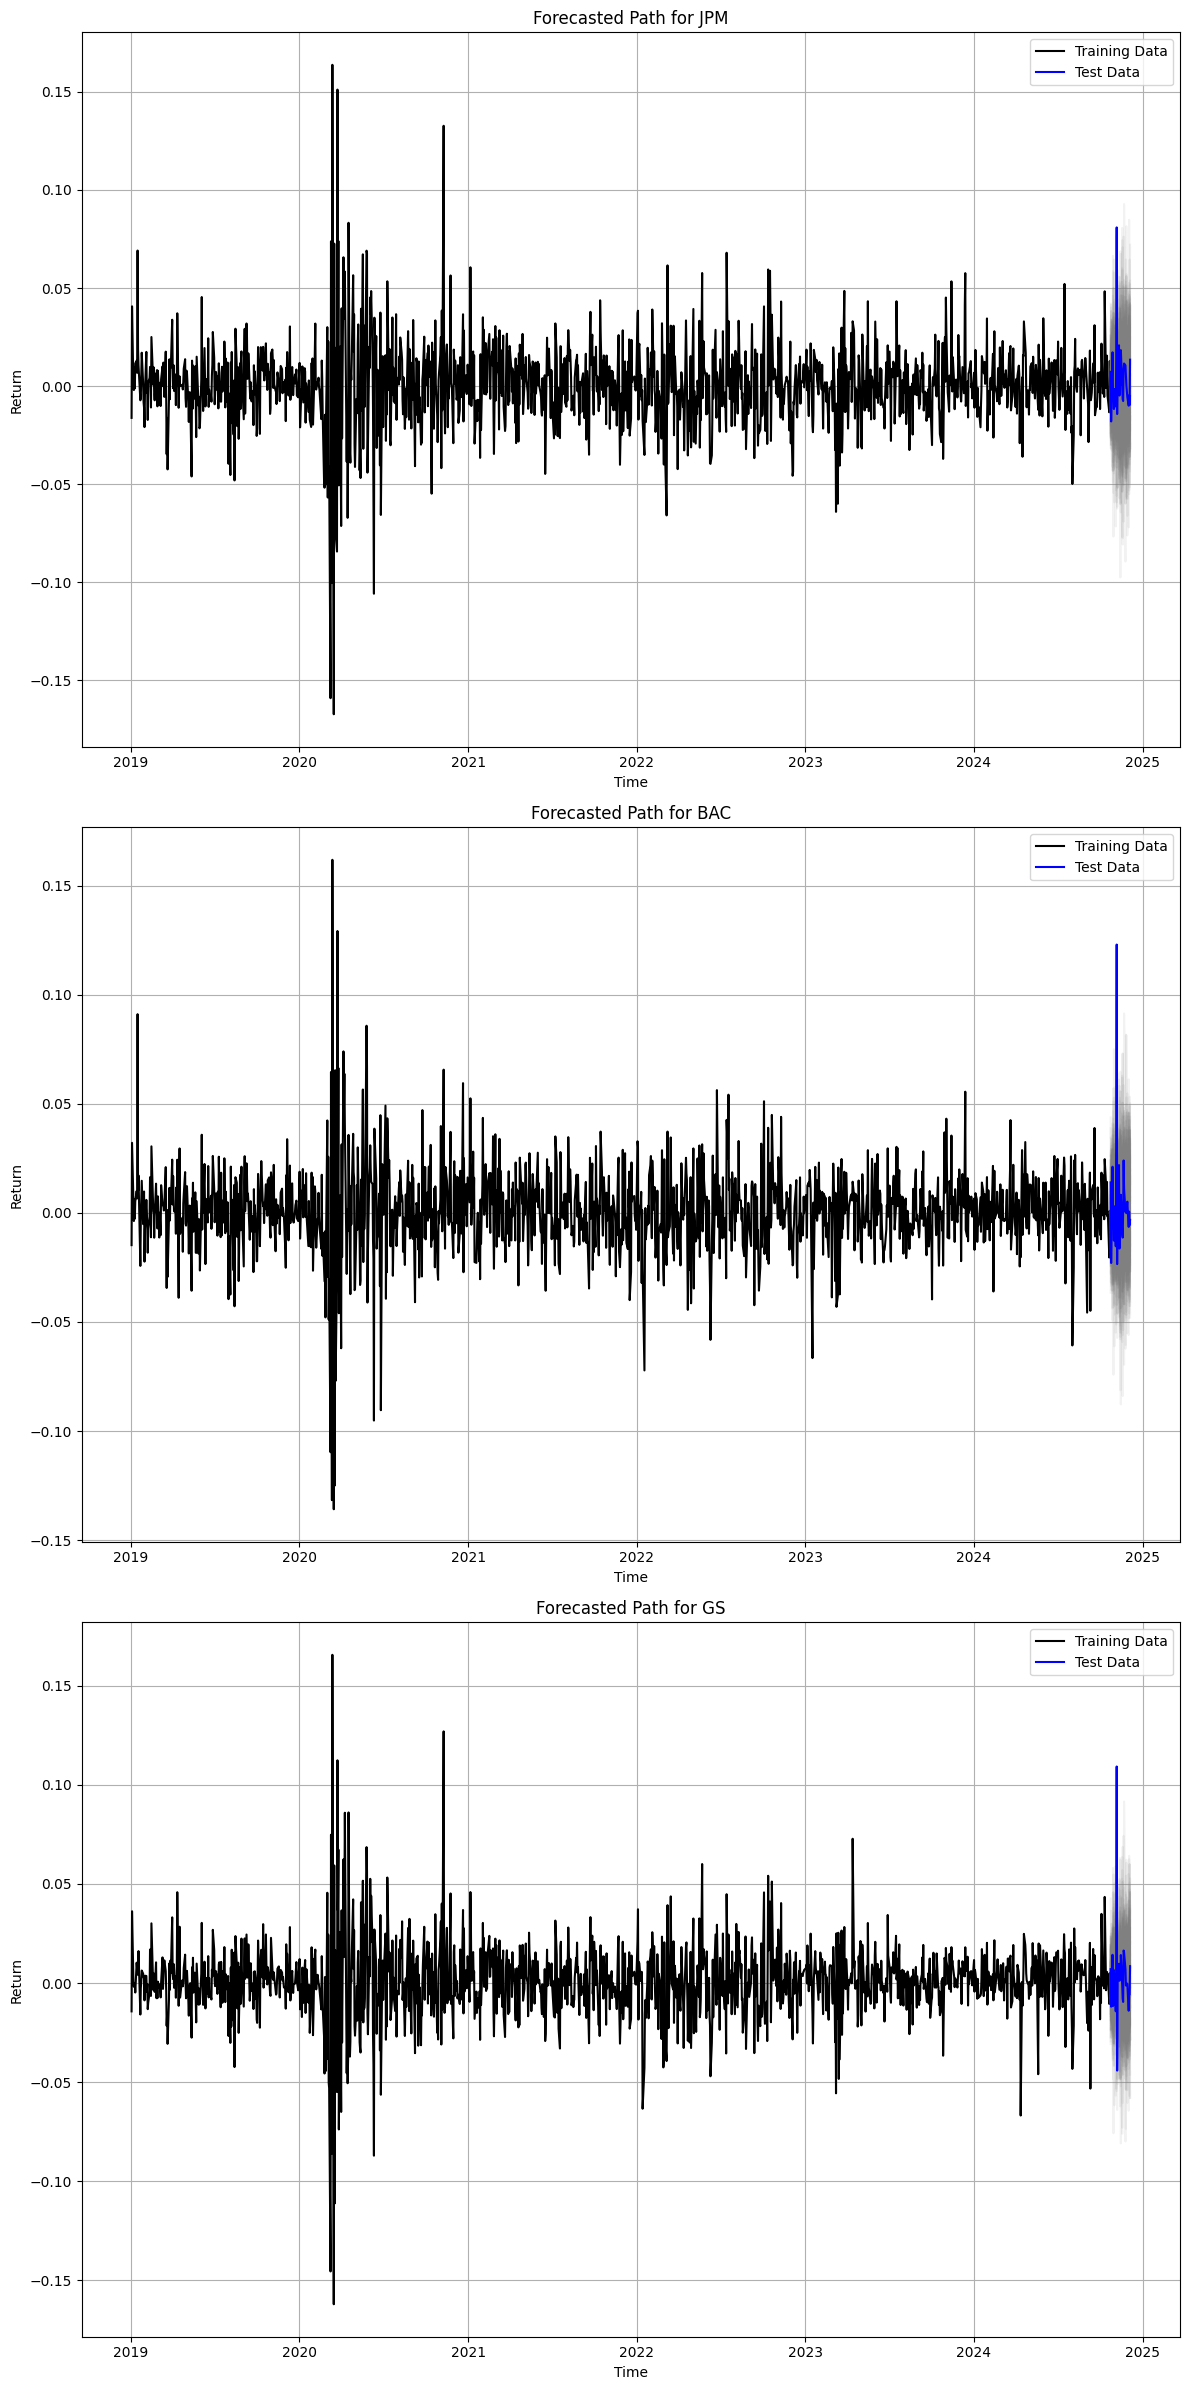

In [11]:
T_forecast = 30
n_samples = 100
y_samples, H_samples = model.sample_forecast(y_matrix, T_forecast, n_samples)

# Visualize one dimension's paths
fig, axs = plt.subplots(n_dims, 1, figsize=(12, 8 * n_dims))

for i in range(n_dims):
    lower_band = np.percentile(y_samples[:, :, i], 5, axis=0)
    upper_band = np.percentile(y_samples[:, :, i], 95, axis=0)

    axs[i].plot(train_timestamps, y_train[:, i], label="Training Data", color="black")
    axs[i].plot(test_timestamps, y_samples[:, :, i].T, color="gray", alpha=0.1)
    axs[i].fill_between(test_timestamps, lower_band, upper_band, color="gray", alpha=0.2)
    axs[i].plot(test_timestamps, y_test[:, i], label="Test Data", color="blue")
    axs[i].set_title(f"Forecasted Path for {syms[i]}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Return")
    axs[i].legend()
    axs[i].grid()

plt.tight_layout()
plt.xlabel("Time")
plt.show()


### Goodness of Fit of the Correlation Forecast

The correlation forecast appears to be a reasonable approximation of the out-of-sample instantaneous correlation estimates based on the actual realized residuals. Here are some key observations:

1. **Mean Forecasted Correlations**: The mean forecasted correlations (blue line) closely follow the trend of the out-of-sample correlations (red line). This indicates that the model captures the overall dynamic behavior of the correlations well.

2. **Confidence Intervals**: The 95% confidence intervals (shaded blue area) around the mean forecasted correlations cover the out-of-sample correlations for most of the forecast period. This suggests that the model's uncertainty estimates are well-calibrated and provide a realistic range for the future correlations.

3. **In-Sample Correlations**: The in-sample correlations (black line) provide a historical context, showing that the model's forecasted correlations are consistent with past behavior. This consistency further supports the model's reliability.

Overall, the correlation forecast demonstrates a good fit, effectively capturing the correlation dynamics and providing reasonable uncertainty estimates. This indicates that the BEKK-GJR(1,1) model is well-suited for forecasting correlations in this multivariate time series context.

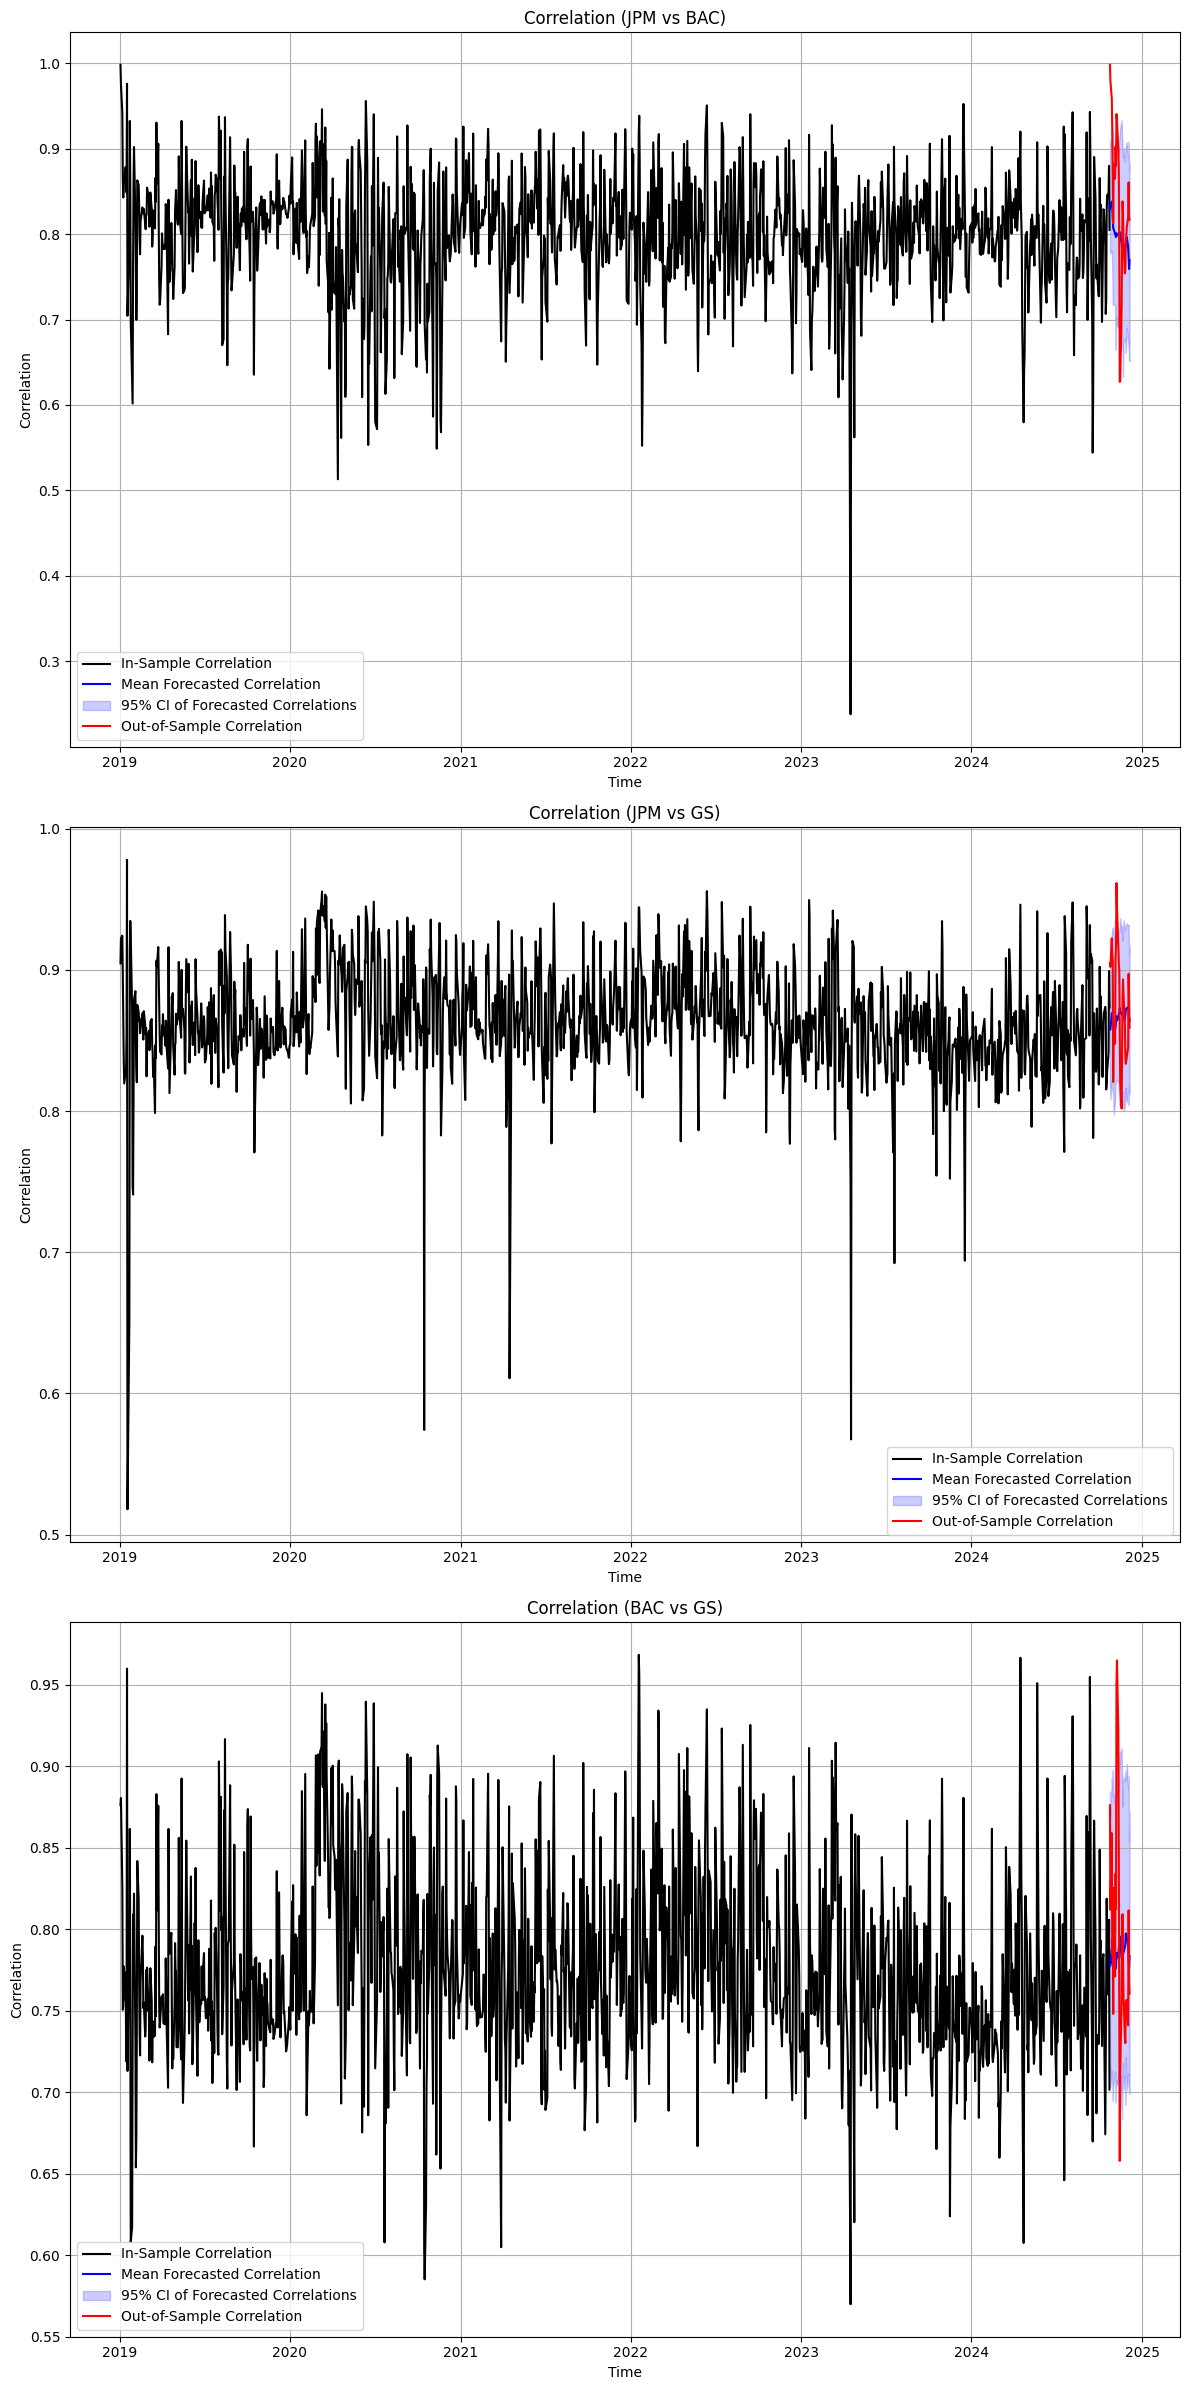

In [12]:



correlation_pairs = [(0, 1), (0, 2), (1, 2)]

in_sample_correlations = extract_correlation_matrix(in_sample_H)
oos_correlations = extract_correlation_matrix(model.conditional_covariances(y_test))

forecast_correlations = np.array([
    extract_correlation_matrix(H_samples[sample]) for sample in range(H_samples.shape[0])
])

# Calculate the mean and confidence intervals of forecasted correlations
mean_forecast_correlations = forecast_correlations.mean(axis=0)
lower_bound_forecast_correlations = np.percentile(forecast_correlations, 5, axis=0)
upper_bound_forecast_correlations = np.percentile(forecast_correlations, 95, axis=0)

# Plot in-sample and forecasted correlations
fig, axs = plt.subplots(len(correlation_pairs), 1, figsize=(12, 8 * len(correlation_pairs)))

for i, (dim1, dim2) in enumerate(correlation_pairs):
    # In-sample correlations
    axs[i].plot(train_timestamps, in_sample_correlations[:, dim1, dim2], label="In-Sample Correlation", color="black")

    # Forecasted correlations
    axs[i].plot(test_timestamps, mean_forecast_correlations[:, dim1, dim2], label="Mean Forecasted Correlation", color="blue")
    axs[i].fill_between(
        test_timestamps,
        lower_bound_forecast_correlations[:, dim1, dim2],
        upper_bound_forecast_correlations[:, dim1, dim2],
        color="blue",
        alpha=0.2,
        label="95% CI of Forecasted Correlations"
    )
    axs[i].plot(test_timestamps, oos_correlations[:, dim1, dim2], label="Out-of-Sample Correlation", color="red")

    axs[i].set_title(f"Correlation ({syms[dim1]} vs {syms[dim2]})")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Correlation")
    axs[i].legend()
    axs[i].grid()

plt.tight_layout()
plt.show()